In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/MLProject/songs-balanced-final.csv')

In [ ]:
import ast
df['merged_labels'] = df['merged_labels'].apply(ast.literal_eval)

In [ ]:
df.shape

(2017, 4)

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
import ast
# df['merged_labels'] = df['merged_labels'].apply(ast.literal_eval)
all_genres=['electronic', 'rock', 'funk&soul', 'pop', 'folk&country', 'hiphop', 'rhythm&blues', 'jazz']
all_moods = ['happy/celebration/party/dance', 'loss/sad/heartbreak/angst/protest', 'romantic/love/passion/devotion', 'motivating/inspirational/uplifting/confidence/nostalgia']
mlb = MultiLabelBinarizer(classes=all_genres + all_moods)
df['labels'] = list(mlb.fit_transform(df['merged_labels']))
labels = mlb.classes_

In [ ]:
print (labels)

['electronic' 'rock' 'funk&soul' 'pop' 'folk&country' 'hiphop'
 'rhythm&blues' 'jazz' 'happy/celebration/party/dance'
 'loss/sad/heartbreak/angst/protest' 'romantic/love/passion/devotion'
 'motivating/inspirational/uplifting/confidence/nostalgia']


In [ ]:
from transformers import ASTFeatureExtractor
import torch
import torchaudio

In [ ]:
feature_extractor = ASTFeatureExtractor()

In [ ]:
def extract_features(file_path):
  waveform, sampling_rate = torchaudio.load(file_path)
  waveform = waveform.squeeze().numpy()
  inputs = feature_extractor(waveform, sampling_rate=sampling_rate, padding="max_length", return_tensors="pt")
  return inputs.input_values

In [ ]:
df['input'] = df['file_path'].apply(lambda x: extract_features(x))

In [ ]:
df.iloc[0]['input'].shape

torch.Size([1, 1024, 128])

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

In [ ]:
from torch.utils.data import Dataset, DataLoader

class LyricsDataset(Dataset):
    def __init__(self, dataframe):
        self.labels = list(dataframe['labels'])
        self.input = list(dataframe['input'])

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # input_tensor = torch.tensor(self.input[idx].numpy(), dtype=torch.float)
        # if input_tensor.dim() == 4:
        #     input_tensor = input_tensor.squeeze(1)
        return {
            'input': torch.tensor(self.input[idx].numpy().squeeze(0), dtype=torch.float),
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

train_dataset = LyricsDataset(train_df)
val_dataset = LyricsDataset(val_df)
test_dataset = LyricsDataset(test_df)

In [ ]:
from transformers import ASTForAudioClassification,ASTConfig

config = ASTConfig.from_pretrained('MIT/ast-finetuned-audioset-10-10-0.4593')
config.num_labels = len(labels)
model = ASTForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593", config=config, ignore_mismatched_sizes=True)

Some weights of ASTForAudioClassification were not initialized from the model checkpoint at MIT/ast-finetuned-audioset-10-10-0.4593 and are newly initialized because the shapes did not match:
- classifier.dense.bias: found shape torch.Size([527]) in the checkpoint and torch.Size([12]) in the model instantiated
- classifier.dense.weight: found shape torch.Size([527, 768]) in the checkpoint and torch.Size([12, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model_path = '/content/drive/MyDrive/MLProject/weights/ast/checkpoints_3_ast.pt'
checkpoint = torch.load(model_path, map_location=torch.device('cpu'))

In [ ]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ASTForAudioClassification(
  (audio_spectrogram_transformer): ASTModel(
    (embeddings): ASTEmbeddings(
      (patch_embeddings): ASTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ASTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ASTLayer(
          (attention): ASTAttention(
            (attention): ASTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ASTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ASTIntermediate(
            (de

In [ ]:
batch_size = 5
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
def exact_match_accuracy(true_labels, predictions):
    exact_match = np.all(true_labels == predictions, axis=1)
    ema_accuracy = np.mean(exact_match)
    genre_true, mood_true = true_labels[:, :8], true_labels[:, 8:]
    genre_pred, mood_pred = predictions[:, :8], predictions[:, 8:]
    exact_match_genre = np.all(genre_true == genre_pred, axis=1)
    exact_match_mood = np.all(mood_true == mood_pred, axis=1)
    exact_match_genres = np.mean(exact_match_genre)
    exact_match_moods = np.mean(exact_match_mood)
    return ema_accuracy, exact_match_genres, exact_match_moods

In [ ]:
from torch.nn import BCEWithLogitsLoss

loss_fn = BCEWithLogitsLoss()

In [ ]:
import os

checkpoint_dir = './checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [ ]:
from transformers import AdamW
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss
from torch.nn import BCEWithLogitsLoss

loss_fn = BCEWithLogitsLoss()
optimizer = AdamW(model.parameters(), lr=1e-5)
epochs = 8

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        optimizer.zero_grad()

        input = batch['input'].to(device)
        # print (batch['input'].shape)
        # print (input.shape)
        # attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        # print (labels.shape)
        outputs = model(input)
        loss = loss_fn(outputs.logits, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Average Training Loss: {avg_train_loss:.4f}")

    if 1 <= epoch <= 7:
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pt')
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_val_loss,
        }, checkpoint_path)
        print(f"Checkpoint saved at {checkpoint_path}")

    # Validation
    model.eval()
    val_loss = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}"):
            input = batch['input'].to(device)
            # attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input)
            loss = loss_fn(outputs.logits, labels)
            val_loss += loss.item()
            predictions.append(torch.sigmoid(outputs.logits).cpu().numpy())
            true_labels.append(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    print(f"Average Validation Loss: {avg_val_loss:.4f}")

    # Calculate metrics
    predictions = np.vstack(predictions)
    true_labels = np.vstack(true_labels)
    threshold = 0.5
    predictions[predictions >= threshold] = 1
    predictions[predictions < threshold] = 0

    f1 = f1_score(true_labels, predictions, average='micro')
    precision = precision_score(true_labels, predictions, average='micro')
    recall = recall_score(true_labels, predictions, average='micro')
    f1_mac = f1_score(true_labels, predictions, average='macro')
    precision_mac = precision_score(true_labels, predictions, average='macro')
    recall_mac = recall_score(true_labels, predictions, average='macro')
    f1_w = f1_score(true_labels, predictions, average='weighted')
    precision_w = precision_score(true_labels, predictions, average='weighted')
    recall_w = recall_score(true_labels, predictions, average='weighted')
    hamming = hamming_loss(true_labels, predictions)
    ema_score, genre_score, mood_score = exact_match_accuracy(true_labels, predictions)

    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("-"*30)
    print(f"Hamming Loss: {hamming:.4f}")
    print(f"F1 Score Macro: {f1_mac:.4f}")
    print(f"Precision Macro: {precision_mac:.4f}")
    print(f"Recall Macro: {recall_mac:.4f}")
    print("-"*30)
    print(f"F1 Score W: {f1_w:.4f}")
    print(f"Precision W: {precision_w:.4f}")
    print(f"Recall W: {recall_w:.4f}")
    print(f"Exact Match Accuracy: {ema_score:.4f}")
    print(f"Exact genre Match Accuracy: {genre_score:.4f}")
    print(f"Exact mood Match Accuracy: {mood_score:.4f}")


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training Epoch 1:   0%|          | 0/258 [00:00<?, ?it/s]

Average Training Loss: 0.3758


Validation Epoch 1:   0%|          | 0/65 [00:00<?, ?it/s]

Average Validation Loss: 0.3292
F1 Score: 0.5908
Precision: 0.7155
Recall: 0.5031
------------------------------
Hamming Loss: 0.1447
F1 Score Macro: 0.5100
Precision Macro: 0.7193
Recall Macro: 0.4433
------------------------------
F1 Score W: 0.5535
Precision W: 0.7055
Recall W: 0.5031
Exact Match Accuracy: 0.1672
Exact genre Match Accuracy: 0.4334
Exact mood Match Accuracy: 0.4118


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 2:   0%|          | 0/258 [00:00<?, ?it/s]

Average Training Loss: 0.2644


Validation Epoch 2:   0%|          | 0/65 [00:00<?, ?it/s]

Average Validation Loss: 0.2918
F1 Score: 0.6662
Precision: 0.7891
Recall: 0.5764
------------------------------
Hamming Loss: 0.1200
F1 Score Macro: 0.6463
Precision Macro: 0.7480
Recall Macro: 0.5789
------------------------------
F1 Score W: 0.6387
Precision W: 0.7359
Recall W: 0.5764
Exact Match Accuracy: 0.2570
Exact genre Match Accuracy: 0.5851
Exact mood Match Accuracy: 0.3994


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training Epoch 3:   0%|          | 0/258 [00:00<?, ?it/s]

Average Training Loss: 0.1812


Validation Epoch 3:   0%|          | 0/65 [00:00<?, ?it/s]

Average Validation Loss: 0.2706
F1 Score: 0.7125
Precision: 0.8542
Recall: 0.6112
------------------------------
Hamming Loss: 0.1024
F1 Score Macro: 0.7256
Precision Macro: 0.8606
Recall Macro: 0.6378
------------------------------
F1 Score W: 0.7006
Precision W: 0.8416
Recall W: 0.6112
Exact Match Accuracy: 0.3622
Exact genre Match Accuracy: 0.6378
Exact mood Match Accuracy: 0.4706


Training Epoch 4:   0%|          | 0/258 [00:00<?, ?it/s]

Average Training Loss: 0.1145


Validation Epoch 4:   0%|          | 0/65 [00:00<?, ?it/s]

Average Validation Loss: 0.2645
F1 Score: 0.7487
Precision: 0.8104
Recall: 0.6957
------------------------------
Hamming Loss: 0.0970
F1 Score Macro: 0.7668
Precision Macro: 0.8501
Recall Macro: 0.7128
------------------------------
F1 Score W: 0.7450
Precision W: 0.8265
Recall W: 0.6957
Exact Match Accuracy: 0.4675
Exact genre Match Accuracy: 0.6718
Exact mood Match Accuracy: 0.6006


Training Epoch 5:   0%|          | 0/258 [00:00<?, ?it/s]

Average Training Loss: 0.0664


Validation Epoch 5:   0%|          | 0/65 [00:00<?, ?it/s]

Average Validation Loss: 0.2716
F1 Score: 0.7463
Precision: 0.8168
Recall: 0.6870
------------------------------
Hamming Loss: 0.0970
F1 Score Macro: 0.7685
Precision Macro: 0.8423
Recall Macro: 0.7155
------------------------------
F1 Score W: 0.7420
Precision W: 0.8199
Recall W: 0.6870
Exact Match Accuracy: 0.4706
Exact genre Match Accuracy: 0.6780
Exact mood Match Accuracy: 0.5449


Training Epoch 6:   0%|          | 0/258 [00:00<?, ?it/s]

Average Training Loss: 0.0387


Validation Epoch 6:   0%|          | 0/65 [00:00<?, ?it/s]

Average Validation Loss: 0.2841
F1 Score: 0.7376
Precision: 0.8119
Recall: 0.6758
------------------------------
Hamming Loss: 0.0998
F1 Score Macro: 0.7674
Precision Macro: 0.8393
Recall Macro: 0.7164
------------------------------
F1 Score W: 0.7322
Precision W: 0.8169
Recall W: 0.6758
Exact Match Accuracy: 0.4675
Exact genre Match Accuracy: 0.6594
Exact mood Match Accuracy: 0.5511


Training Epoch 7:   0%|          | 0/258 [00:00<?, ?it/s]

Average Training Loss: 0.0243


Validation Epoch 7:   0%|          | 0/65 [00:00<?, ?it/s]

Average Validation Loss: 0.2743
F1 Score: 0.7662
Precision: 0.8261
Recall: 0.7143
------------------------------
Hamming Loss: 0.0906
F1 Score Macro: 0.7863
Precision Macro: 0.8518
Recall Macro: 0.7352
------------------------------
F1 Score W: 0.7648
Precision W: 0.8299
Recall W: 0.7143
Exact Match Accuracy: 0.5139
Exact genre Match Accuracy: 0.6904
Exact mood Match Accuracy: 0.6068


Training Epoch 8:   0%|          | 0/258 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

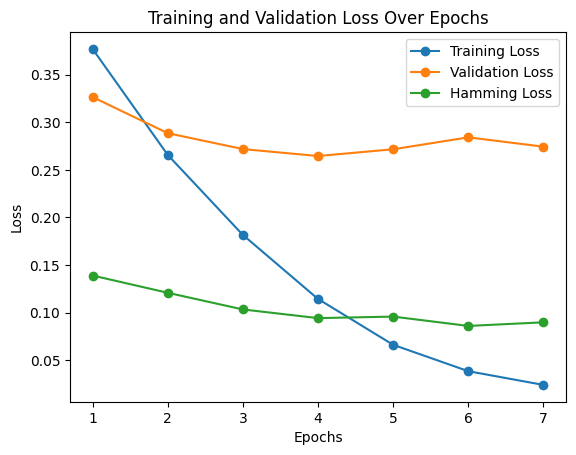

In [ ]:
import matplotlib.pyplot as plt
validation_loss = [0.3264, 0.2885, 0.2718, 0.2645, 0.2716, 0.2841, 0.2743]
train_loss = [0.3769, 0.2657, 0.1817, 0.1145, 0.0664, 0.0387, 0.0243]
hamming_loss =[0.1391,0.1210,0.1035,0.0944,0.0960,0.0862,0.0900]
epochs = range(1, 8)

# Plotting the training and validation loss
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='o')
plt.plot(epochs, hamming_loss, label='Hamming Loss', marker='o')


# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

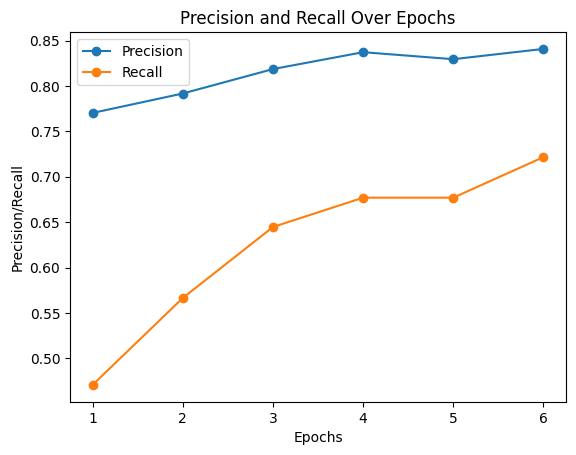

In [ ]:
import matplotlib.pyplot as plt
precision = [0.7703, 0.7917, 0.8186, 0.8372, 0.8295, 0.8408]
recall = [0.4708, 0.5665, 0.6447, 0.6770, 0.6770, 0.7217]
epochs = range(1, 7)

# Plotting the training and validation loss
plt.plot(epochs, precision, label='Precision', marker='o')
plt.plot(epochs, recall, label='Recall', marker='o')


# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Precision/Recall')
plt.title('Precision and Recall Over Epochs')

# Adding a legend
plt.legend()

# Display the plot
plt.show()

### balanced 2 - this is the final model we are using

In [ ]:
from transformers import AdamW
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss
from torch.nn import BCEWithLogitsLoss

loss_fn = BCEWithLogitsLoss()
optimizer = AdamW(model.parameters(), lr=1e-5)
epochs = 8

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        optimizer.zero_grad()

        input = batch['input'].to(device)
        # print (batch['input'].shape)
        # print (input.shape)
        # attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        # print (labels.shape)
        outputs = model(input)
        loss = loss_fn(outputs.logits, labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f"Average Training Loss: {avg_train_loss:.4f}")

    if 1 <= epoch <= 7:
        checkpoint_path = os.path.join(checkpoint_dir, f'checkpoint_epoch_{epoch+1}.pt')
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_val_loss,
        }, checkpoint_path)
        print(f"Checkpoint saved at {checkpoint_path}")

    # Validation
    model.eval()
    val_loss = 0
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}"):
            input = batch['input'].to(device)
            # attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input)
            loss = loss_fn(outputs.logits, labels)
            val_loss += loss.item()
            predictions.append(torch.sigmoid(outputs.logits).cpu().numpy())
            true_labels.append(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    print(f"Average Validation Loss: {avg_val_loss:.4f}")

    # Calculate metrics
    predictions = np.vstack(predictions)
    true_labels = np.vstack(true_labels)
    threshold = 0.5
    predictions[predictions >= threshold] = 1
    predictions[predictions < threshold] = 0

    f1 = f1_score(true_labels, predictions, average='micro')
    precision = precision_score(true_labels, predictions, average='micro')
    recall = recall_score(true_labels, predictions, average='micro')
    f1_mac = f1_score(true_labels, predictions, average='macro')
    precision_mac = precision_score(true_labels, predictions, average='macro')
    recall_mac = recall_score(true_labels, predictions, average='macro')
    f1_w = f1_score(true_labels, predictions, average='weighted')
    precision_w = precision_score(true_labels, predictions, average='weighted')
    recall_w = recall_score(true_labels, predictions, average='weighted')
    hamming = hamming_loss(true_labels, predictions)
    ema_score, genre_score, mood_score = exact_match_accuracy(true_labels, predictions)

    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("-"*30)
    print(f"Hamming Loss: {hamming:.4f}")
    print(f"F1 Score Macro: {f1_mac:.4f}")
    print(f"Precision Macro: {precision_mac:.4f}")
    print(f"Recall Macro: {recall_mac:.4f}")
    print("-"*30)
    print(f"F1 Score W: {f1_w:.4f}")
    print(f"Precision W: {precision_w:.4f}")
    print(f"Recall W: {recall_w:.4f}")
    print(f"Exact Match Accuracy: {ema_score:.4f}")
    print(f"Exact genre Match Accuracy: {genre_score:.4f}")
    print(f"Exact mood Match Accuracy: {mood_score:.4f}")


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training Epoch 1:   0%|          | 0/258 [00:00<?, ?it/s]

Average Training Loss: 0.3769


Validation Epoch 1:   0%|          | 0/65 [00:00<?, ?it/s]

Average Validation Loss: 0.3264
F1 Score: 0.5844
Precision: 0.7703
Recall: 0.4708
------------------------------
Hamming Loss: 0.1391
F1 Score Macro: 0.5239
Precision Macro: 0.7703
Recall Macro: 0.4508
------------------------------
F1 Score W: 0.5347
Precision W: 0.7646
Recall W: 0.4708
Exact Match Accuracy: 0.1207
Exact genre Match Accuracy: 0.4861
Exact mood Match Accuracy: 0.2539


Training Epoch 2:   0%|          | 0/258 [00:00<?, ?it/s]

Average Training Loss: 0.2657
Checkpoint saved at ./checkpoints/checkpoint_epoch_2.pt


Validation Epoch 2:   0%|          | 0/65 [00:00<?, ?it/s]

Average Validation Loss: 0.2885
F1 Score: 0.6604
Precision: 0.7917
Recall: 0.5665
------------------------------
Hamming Loss: 0.1210
F1 Score Macro: 0.6407
Precision Macro: 0.8206
Recall Macro: 0.5657
------------------------------
F1 Score W: 0.6377
Precision W: 0.8046
Recall W: 0.5665
Exact Match Accuracy: 0.2415
Exact genre Match Accuracy: 0.5418
Exact mood Match Accuracy: 0.3839


Training Epoch 3:   0%|          | 0/258 [00:00<?, ?it/s]

Average Training Loss: 0.1817
Checkpoint saved at ./checkpoints/checkpoint_epoch_3.pt


Validation Epoch 3:   0%|          | 0/65 [00:00<?, ?it/s]

Average Validation Loss: 0.2718
F1 Score: 0.7213
Precision: 0.8186
Recall: 0.6447
------------------------------
Hamming Loss: 0.1035
F1 Score Macro: 0.7317
Precision Macro: 0.8415
Recall Macro: 0.6704
------------------------------
F1 Score W: 0.7102
Precision W: 0.8300
Recall W: 0.6447
Exact Match Accuracy: 0.3932
Exact genre Match Accuracy: 0.6594
Exact mood Match Accuracy: 0.4923


Training Epoch 4:   0%|          | 0/258 [00:00<?, ?it/s]

Average Training Loss: 0.1135
Checkpoint saved at ./checkpoints/checkpoint_epoch_4.pt


Validation Epoch 4:   0%|          | 0/65 [00:00<?, ?it/s]

Average Validation Loss: 0.2567
F1 Score: 0.7486
Precision: 0.8372
Recall: 0.6770
------------------------------
Hamming Loss: 0.0944
F1 Score Macro: 0.7609
Precision Macro: 0.8560
Recall Macro: 0.6935
------------------------------
F1 Score W: 0.7463
Precision W: 0.8396
Recall W: 0.6770
Exact Match Accuracy: 0.4365
Exact genre Match Accuracy: 0.6687
Exact mood Match Accuracy: 0.5449


Training Epoch 5:   0%|          | 0/258 [00:00<?, ?it/s]

Average Training Loss: 0.0638
Checkpoint saved at ./checkpoints/checkpoint_epoch_5.pt


Validation Epoch 5:   0%|          | 0/65 [00:00<?, ?it/s]

Average Validation Loss: 0.2641
F1 Score: 0.7456
Precision: 0.8295
Recall: 0.6770
------------------------------
Hamming Loss: 0.0960
F1 Score Macro: 0.7703
Precision Macro: 0.8426
Recall Macro: 0.7132
------------------------------
F1 Score W: 0.7429
Precision W: 0.8287
Recall W: 0.6770
Exact Match Accuracy: 0.4613
Exact genre Match Accuracy: 0.6842
Exact mood Match Accuracy: 0.5573


Training Epoch 6:   0%|          | 0/258 [00:00<?, ?it/s]

Average Training Loss: 0.0370
Checkpoint saved at ./checkpoints/checkpoint_epoch_6.pt


Validation Epoch 6:   0%|          | 0/65 [00:00<?, ?it/s]

Average Validation Loss: 0.2632
F1 Score: 0.7767
Precision: 0.8408
Recall: 0.7217
------------------------------
Hamming Loss: 0.0862
F1 Score Macro: 0.7957
Precision Macro: 0.8739
Recall Macro: 0.7380
------------------------------
F1 Score W: 0.7740
Precision W: 0.8445
Recall W: 0.7217
Exact Match Accuracy: 0.5201
Exact genre Match Accuracy: 0.7059
Exact mood Match Accuracy: 0.6037


Training Epoch 7:   0%|          | 0/258 [00:00<?, ?it/s]

Average Training Loss: 0.0237
Checkpoint saved at ./checkpoints/checkpoint_epoch_7.pt


Validation Epoch 7:   0%|          | 0/65 [00:00<?, ?it/s]

Average Validation Loss: 0.2705
F1 Score: 0.7647
Precision: 0.8363
Recall: 0.7043
------------------------------
Hamming Loss: 0.0900
F1 Score Macro: 0.7907
Precision Macro: 0.8641
Recall Macro: 0.7326
------------------------------
F1 Score W: 0.7637
Precision W: 0.8384
Recall W: 0.7043
Exact Match Accuracy: 0.4923
Exact genre Match Accuracy: 0.6935
Exact mood Match Accuracy: 0.5882


Training Epoch 8:   0%|          | 0/258 [00:00<?, ?it/s]

Average Training Loss: 0.0170
Checkpoint saved at ./checkpoints/checkpoint_epoch_8.pt


Validation Epoch 8:   0%|          | 0/65 [00:00<?, ?it/s]

Average Validation Loss: 0.2756
F1 Score: 0.7685
Precision: 0.8385
Recall: 0.7093
------------------------------
Hamming Loss: 0.0888
F1 Score Macro: 0.7938
Precision Macro: 0.8718
Recall Macro: 0.7331
------------------------------
F1 Score W: 0.7684
Precision W: 0.8441
Recall W: 0.7093
Exact Match Accuracy: 0.5108
Exact genre Match Accuracy: 0.6966
Exact mood Match Accuracy: 0.6037


In [ ]:
checkpoint_path = '/content/checkpoints/checkpoint_epoch_6.pt'  # Update this path
checkpoint = torch.load(checkpoint_path)

model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']
loss = checkpoint['loss']

# Now you can continue training from the start_epoch or evaluate the model


###balanced 2 test chk 3 - this is the final checkpoint we are using

In [ ]:
# Set the model to evaluation mode
from transformers import AdamW
from tqdm.auto import tqdm
from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss, multilabel_confusion_matrix
from torch.nn import BCEWithLogitsLoss
model.eval()
from sklearn.metrics import f1_score, precision_score, recall_score, hamming_loss

# Initialize variables to store results
test_loss = 0
test_predictions = []
test_true_labels = []

# Loss function
loss_fn = BCEWithLogitsLoss()

# No gradient is needed for evaluation
with torch.no_grad():
    for batch in test_loader:
        input = batch['input'].to(device)
        # attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input)
        loss = loss_fn(outputs.logits, labels)
        test_loss += loss.item()

        # Store predictions and true labels
        test_predictions.append(torch.sigmoid(outputs.logits).cpu().numpy())
        test_true_labels.append(labels.cpu().numpy())

# Calculate average loss
average_test_loss = test_loss / len(test_loader)
print(f"Average Test Loss: {average_test_loss:.4f}")

# Flatten the outputs
test_predictions = np.vstack(test_predictions)
test_true_labels = np.vstack(test_true_labels)

# Convert probabilities to binary predictions
threshold = 0.5
test_predictions[test_predictions >= threshold] = 1
test_predictions[test_predictions < threshold] = 0

# Calculate metrics
f1 = f1_score(test_true_labels, test_predictions, average='micro')
precision = precision_score(test_true_labels, test_predictions, average='micro')
recall = recall_score(test_true_labels, test_predictions, average='micro')
f1_mac = f1_score(test_true_labels, test_predictions, average='macro')
precision_mac = precision_score(test_true_labels, test_predictions, average='macro')
recall_mac = recall_score(test_true_labels, test_predictions, average='macro')
f1_w = f1_score(test_true_labels, test_predictions, average='weighted')
precision_w = precision_score(test_true_labels, test_predictions, average='weighted')
recall_w = recall_score(test_true_labels, test_predictions, average='weighted')
hamming = hamming_loss(test_true_labels, test_predictions)
ema_score, genre_score, mood_score = exact_match_accuracy(test_true_labels, test_predictions)
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("-"*30)
print(f"Hamming Loss: {hamming:.4f}")
print(f"F1 Score Macro: {f1_mac:.4f}")
print(f"Precision Macro: {precision_mac:.4f}")
print(f"Recall Macro: {recall_mac:.4f}")
print("-"*30)
print(f"F1 Score W: {f1_w:.4f}")
print(f"Precision W: {precision_w:.4f}")
print(f"Recall W: {recall_w:.4f}")
print(f"Exact Match Accuracy: {ema_score:.4f}")
print(f"Exact Match Accuracy genre: {genre_score:.4f}")
print(f"Exact Match Accuracy mood: {mood_score:.4f}")


Average Test Loss: 0.2522
[[358  10]
 [ 10  26]]
[[274  16]
 [ 27  87]]
[[332   4]
 [  7  61]]
[[300  13]
 [ 27  64]]
[[317   2]
 [ 19  66]]
[[308   9]
 [ 10  77]]
[[363   1]
 [  8  32]]
[[357   1]
 [  5  41]]
[[242  47]
 [ 30  85]]
[[258  26]
 [ 69  51]]
[[294  13]
 [ 53  44]]
[[330   2]
 [ 46  26]]
F1 Score: 0.7437
Precision: 0.8209
Recall: 0.6797
------------------------------
Hamming Loss: 0.0939
F1 Score Macro: 0.7552
Precision Macro: 0.8463
Recall Macro: 0.7015
------------------------------
F1 Score W: 0.7332
Precision W: 0.8250
Recall W: 0.6797
Exact Match Accuracy: 0.4035
Exact Match Accuracy genre: 0.6881
Exact Match Accuracy mood: 0.5025


###balanced 2 test chk 4

In [ ]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to store results
test_loss = 0
test_predictions = []
test_true_labels = []

# Loss function
loss_fn = BCEWithLogitsLoss()

# No gradient is needed for evaluation
with torch.no_grad():
    for batch in test_loader:
        input = batch['input'].to(device)
        # attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input)
        loss = loss_fn(outputs.logits, labels)
        test_loss += loss.item()

        # Store predictions and true labels
        test_predictions.append(torch.sigmoid(outputs.logits).cpu().numpy())
        test_true_labels.append(labels.cpu().numpy())

# Calculate average loss
average_test_loss = test_loss / len(test_loader)
print(f"Average Test Loss: {average_test_loss:.4f}")

# Flatten the outputs
test_predictions = np.vstack(test_predictions)
test_true_labels = np.vstack(test_true_labels)

# Convert probabilities to binary predictions
threshold = 0.5
test_predictions[test_predictions >= threshold] = 1
test_predictions[test_predictions < threshold] = 0

# Calculate metrics
f1 = f1_score(test_true_labels, test_predictions, average='micro')
precision = precision_score(test_true_labels, test_predictions, average='micro')
recall = recall_score(test_true_labels, test_predictions, average='micro')
f1_mac = f1_score(test_true_labels, test_predictions, average='macro')
precision_mac = precision_score(test_true_labels, test_predictions, average='macro')
recall_mac = recall_score(test_true_labels, test_predictions, average='macro')
f1_w = f1_score(test_true_labels, test_predictions, average='weighted')
precision_w = precision_score(test_true_labels, test_predictions, average='weighted')
recall_w = recall_score(test_true_labels, test_predictions, average='weighted')
hamming = hamming_loss(test_true_labels,test_predictions)
ema_score, genre_score, mood_score = exact_match_accuracy(test_true_labels, test_predictions)
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("-"*30)
print(f"Hamming Loss: {hamming:.4f}")
print(f"F1 Score Macro: {f1_mac:.4f}")
print(f"Precision Macro: {precision_mac:.4f}")
print(f"Recall Macro: {recall_mac:.4f}")
print("-"*30)
print(f"F1 Score W: {f1_w:.4f}")
print(f"Precision W: {precision_w:.4f}")
print(f"Recall W: {recall_w:.4f}")
print(f"Exact Match Accuracy: {ema_score:.4f}")
print(f"Exact Match Accuracy genre: {genre_score:.4f}")
print(f"Exact Match Accuracy mood: {mood_score:.4f}")


Average Test Loss: 0.2522
F1 Score: 0.7437
Precision: 0.8209
Recall: 0.6797
------------------------------
Hamming Loss: 0.0939
F1 Score Macro: 0.7552
Precision Macro: 0.8463
Recall Macro: 0.7015
------------------------------
F1 Score W: 0.7332
Precision W: 0.8250
Recall W: 0.6797
Exact Match Accuracy: 0.4035
Exact Match Accuracy genre: 0.6881
Exact Match Accuracy mood: 0.5025


### balanced 2 test chk 6

In [ ]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to store results
test_loss = 0
test_predictions = []
test_true_labels = []

# Loss function
loss_fn = BCEWithLogitsLoss()

# No gradient is needed for evaluation
with torch.no_grad():
    for batch in test_loader:
        input = batch['input'].to(device)
        # attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input)
        loss = loss_fn(outputs.logits, labels)
        test_loss += loss.item()

        # Store predictions and true labels
        test_predictions.append(torch.sigmoid(outputs.logits).cpu().numpy())
        test_true_labels.append(labels.cpu().numpy())

# Calculate average loss
average_test_loss = test_loss / len(test_loader)
print(f"Average Test Loss: {average_test_loss:.4f}")

# Flatten the outputs
test_predictions = np.vstack(test_predictions)
test_true_labels = np.vstack(test_true_labels)

# Convert probabilities to binary predictions
threshold = 0.5
test_predictions[test_predictions >= threshold] = 1
test_predictions[test_predictions < threshold] = 0

# Calculate metrics
f1 = f1_score(true_labels, predictions, average='micro')
precision = precision_score(true_labels, predictions, average='micro')
recall = recall_score(true_labels, predictions, average='micro')
f1_mac = f1_score(true_labels, predictions, average='macro')
precision_mac = precision_score(true_labels, predictions, average='macro')
recall_mac = recall_score(true_labels, predictions, average='macro')
f1_w = f1_score(true_labels, predictions, average='weighted')
precision_w = precision_score(true_labels, predictions, average='weighted')
recall_w = recall_score(true_labels, predictions, average='weighted')
hamming = hamming_loss(true_labels, predictions)
ema_score, genre_score, mood_score = exact_match_accuracy(true_labels, predictions)
print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("-"*30)
print(f"Hamming Loss: {hamming:.4f}")
print(f"F1 Score Macro: {f1_mac:.4f}")
print(f"Precision Macro: {precision_mac:.4f}")
print(f"Recall Macro: {recall_mac:.4f}")
print("-"*30)
print(f"F1 Score W: {f1_w:.4f}")
print(f"Precision W: {precision_w:.4f}")
print(f"Recall W: {recall_w:.4f}")
print(f"Exact Match Accuracy: {ema_score:.4f}")
print(f"Exact Match Accuracy genre: {genre_score:.4f}")
print(f"Exact Match Accuracy mood: {mood_score:.4f}")


Average Test Loss: 0.2423
F1 Score: 0.7685
Precision: 0.8385
Recall: 0.7093
------------------------------
Hamming Loss: 0.0888
F1 Score Macro: 0.7938
Precision Macro: 0.8718
Recall Macro: 0.7331
------------------------------
F1 Score W: 0.7684
Precision W: 0.8441
Recall W: 0.7093
Exact Match Accuracy: 0.5108
Exact Match Accuracy genre: 0.6966
Exact Match Accuracy mood: 0.6037


In [ ]:
import shutil

# Define the source folder path (local workspace) and destination folder path (Google Drive)
source_folder = '/content/checkpoints/checkpoint_epoch_3.pt'
destination_folder = '/content/drive/My Drive/checkpoints_3_ast.pt'

# Use shutil.move to move the folder
shutil.move(source_folder, destination_folder)

'/content/drive/My Drive/checkpoints_3_ast.pt'

In [ ]:
import shutil

# Define the source folder path (local workspace) and destination folder path (Google Drive)
source_folder = '/content/checkpoints/checkpoint_epoch_4.pt'
destination_folder = '/content/drive/My Drive/checkpoints_4_ast.pt'

# Use shutil.move to move the folder
shutil.move(source_folder, destination_folder)

'/content/drive/My Drive/checkpoints_4_ast.pt'

In [ ]:
df.iloc[3]['input'].shape

torch.Size([1, 1024, 128])

In [ ]:
df['ast_embd']=''
c=0
for idx,row in df.iterrows():
  model.eval()
  with torch.no_grad():
    input = row['input'].to(device)
    outputs = model(input , output_hidden_states=True)
    embds = outputs.hidden_states[-1]
    pooled = embds.mean(dim=1)
    df.at[idx, 'ast_embd'] = pooled.cpu().numpy()
    c+=1
    if c%50==0:
      print (f"Done {c}")

Done 50
Done 100
Done 150
Done 200
Done 250
Done 300
Done 350
Done 400
Done 450
Done 500
Done 550
Done 600
Done 650
Done 700
Done 750
Done 800
Done 850
Done 900
Done 950
Done 1000
Done 1050
Done 1100
Done 1150
Done 1200
Done 1250
Done 1300
Done 1350
Done 1400
Done 1450
Done 1500
Done 1550
Done 1600
Done 1650
Done 1700
Done 1750
Done 1800
Done 1850
Done 1900
Done 1950
Done 2000


In [ ]:
model.eval()
with torch.no_grad():
  outputs = model(df.iloc[3]['input'].to(device), output_hidden_states=True)
  embds = outputs.hidden_states[-1]
  print (embds.shape)
  pooled = embds.mean(dim=1)
  print (pooled.shape)
  cp = pooled.cpu().numpy()
  print (cp.shape)

torch.Size([1, 1214, 768])
torch.Size([1, 768])
(1, 768)


In [ ]:
outputs[0]

tensor([[-0.8067,  5.1354, -5.2231, -1.8642, -3.8934, -4.1160, -4.4923, -5.0286,
          0.0148, -1.6468, -2.6475, -0.9703]], device='cuda:0')

In [ ]:
type(outputs)

transformers.modeling_outputs.SequenceClassifierOutput

In [ ]:
len(outputs)

2

In [ ]:
len(outputs.hidden_states)

13

In [ ]:
len(outputs[1])

13

In [ ]:
outputs.hidden_states[-1].shape

torch.Size([1, 1214, 768])

In [ ]:
df.head()

,merged_labels,base_path,file_path,video_id,labels,input,ast_embd
0,"[electronic, rock, happy/celebration/party/dance]",rock/-i2Kn-EXh_A#rock#Super Furry Animals - (D...,/content/drive/MyDrive/MLProject/spectrogram-w...,-i2Kn-EXh_A,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]","[[[tensor(0.2171), tensor(-0.1392), tensor(0.2...","[[0.44196892, 0.088439256, -0.0058919415, -0.8..."
1,"[rock, loss/sad/heartbreak/angst/protest]",rock/-JJAXwAaA2w#rock#Placebo - The Bitter End...,/content/drive/MyDrive/MLProject/spectrogram-w...,-JJAXwAaA2w,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]","[[[tensor(0.2287), tensor(-0.0494), tensor(0.3...","[[0.4230424, -0.16559494, -0.06557554, -0.9439..."
2,"[rock, funk&soul, romantic/love/passion/devotion]",rock/-nqRkAsZumc#rock#Incubus - Stellar.webm,/content/drive/MyDrive/MLProject/spectrogram-w...,-nqRkAsZumc,"[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[[[tensor(-0.0379), tensor(-0.1932), tensor(0....","[[0.36016235, -0.3108365, 0.39340565, -0.69319..."
3,"[rock, motivating/inspirational/uplifting/conf...",rock/-Ue193sAcrE#rock#Maximo Park - Apply Some...,/content/drive/MyDrive/MLProject/spectrogram-w...,-Ue193sAcrE,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[[[tensor(0.2200), tensor(-0.0275), tensor(0.3...","[[0.43042052, -0.18589644, -0.03246822, -1.133..."
4,"[rock, loss/sad/heartbreak/angst/protest]",rock/-_EprMTJPWA#rock#Idlewild - American Engl...,/content/drive/MyDrive/MLProject/spectrogram-w...,-_EprMTJPWA,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]","[[[tensor(0.1659), tensor(-0.2808), tensor(0.0...","[[0.48422807, -0.24950458, -0.10614036, -0.874..."


In [ ]:
df.columns

Index(['merged_labels', 'base_path', 'file_path', 'video_id', 'labels',
       'input', 'ast_embd'],
      dtype='object')

In [ ]:
final_df = df[['merged_labels', 'base_path', 'file_path', 'video_id', 'labels', 'ast_embd']]

In [ ]:
final_df.to_csv('/content/drive/MyDrive/MLProject/song-embeddings.csv', index=False)

In [ ]:
final_df.to_pickle('/content/drive/MyDrive/MLProject/song-embeddings.pkl')